In [1]:
import numpy as np
import pandas as pd
import scipy.io as io
import os
from os.path import isfile
import re

import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
sample_len = 1024
scaler = MinMaxScaler() 
label = []
Dataset = []

for file in os.listdir('./Data'):
    if '.mat' in file:
        idx = int(re.split(r'.mat',file)[0])
        data = io.loadmat('./Data/'+file)
        for key in data.keys():
            if 'DE' in key:
                DE = data[key]
            if 'FE' in key :
                FE = data[key]
        n_ = DE.shape[0]//sample_len
        data = np.concatenate([DE,FE],axis=1)
        data = data[:n_*sample_len]
        #data = scaler.fit_transform(data)
        data = data.reshape(n_,sample_len,2)
        Dataset.append(data)
        
        if idx in [97,98,99,100]:
            label.append(np.zeros(n_))
        elif idx>=278:
            label.append(2*np.ones(n_))
        else:
            label.append(np.ones(n_))
            
Dataset = np.concatenate(Dataset,axis=0)
label = np.concatenate(label)

In [3]:
def signal_filter(sig):
    ff = np.fft.fft(sig)
    ff[128:896]=0
    return np.fft.ifft(ff)

for i,data_slice in enumerate(Dataset):
    Dataset[i][:,0] = signal_filter(data_slice[:,0])
    Dataset[i][:,1] = signal_filter(data_slice[:,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [4]:
np.random.seed(5)
n_ = Dataset.shape[0]
shuffle_id = np.random.permutation(np.arange(n_))
Dataset = Dataset[shuffle_id]
label = label[shuffle_id]

training_set = Dataset[:int(n_*0.7)]
test_set = Dataset[int(n_*0.7):]
train_label = label[:int(n_*0.7)]
test_label = label[int(n_*0.7):]

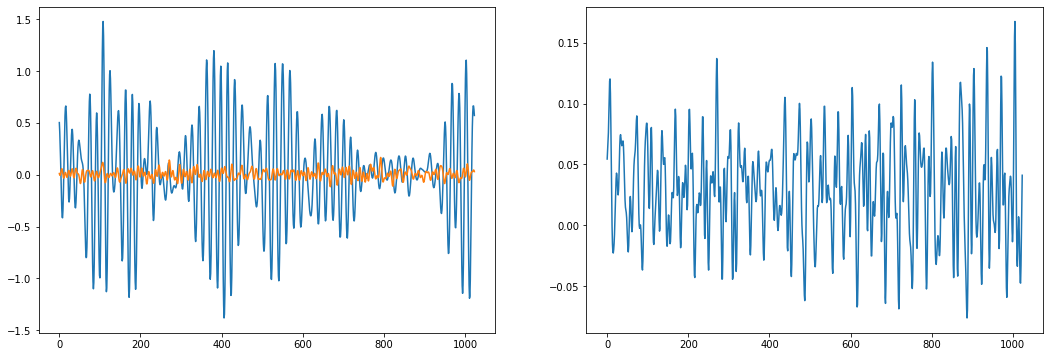

In [5]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(training_set[0][:,0])
plt.plot(training_set[50][:,0])
plt.subplot(1,2,2)

plt.plot(training_set[50][:,1])

In [6]:
def encoder_block0(
    fileter_size,
    kernel_size,
    stride_size,
    input_layer,
    name=None
):
    cnn_output = layers.Conv1D(
        filters=fileter_size,
        kernel_size=kernel_size,
        strides=stride_size,
        padding="same",
        activation="relu",
        name=f'conv_{name}'
    )(input_layer)
    return cnn_output

In [7]:
cnn_name_list = ['block1','block2','block3','block4','block5','encoder_l6','encoder_l7','encoded',
                'decoder_l7','decoder_l6','decoder_l5','decoder_l4','decoder_l3','decoder_l2','decoder_l1','decoder_l0']

input_sig0 = keras.Input(shape=(1024,2),name="input_signal0")
#0621para
f0 = input_sig0.shape[2]
f1,k1,s1 = 32,40,2
l1 = input_sig0.shape[1]//2
f2,k2,s2 = 64,20,2
l2 = l1//2
f3,k3,s3 = 64,10,2
l3 = l2//2
f4,k4,s4 = 32,5,2
l4 = l3//2
f5,k5,s5 = 16,3,2
l5 = l4//2
encoded01 = encoder_block0(f1,k1,s1,input_sig0,cnn_name_list[0]+'0')
encoded02= encoder_block0(f2,k2,s2,encoded01,cnn_name_list[1]+'0')
encoded03 = encoder_block0(f3,k3,s3,encoded02,cnn_name_list[2]+'0')
encoded04 = encoder_block0(f4,k4,s4,encoded03,cnn_name_list[3]+'0')
encoded05 = encoder_block0(f5,k5,s5,encoded04,cnn_name_list[4]+'0')
#encoded05 = encoder_block0(f6,k6,s6,encoded005)
encoded05 = layers.Flatten()(encoded05)
encoded07 = layers.Dense(200,activation="relu",name=cnn_name_list[5]+'0')(encoded05)
encoded08 = layers.Dense(50,activation="relu",name=cnn_name_list[6]+'0')(encoded07)
encoded0 = layers.Dense(3,name=cnn_name_list[7]+'0')(encoded08)
decoder08 = layers.Dense(50,activation="relu",name=cnn_name_list[8]+'0')(encoded0)
decoder07 = layers.Dense(200,activation="relu",name=cnn_name_list[9]+'0')(decoder08)
decoder05 = layers.Dense(l5*f5,activation="relu",name=cnn_name_list[10]+'0')(decoder07)
decoder05 = layers.Reshape((l5,f5))(decoder05)
#decoder005 = layers.Conv1DTranspose(filters=f6, kernel_size=k6, strides=2, activation="relu",padding="same")(decoder05)
decoder04 = layers.Conv1DTranspose(filters=f5, kernel_size=k5, strides=2, activation="relu",padding="same",name=cnn_name_list[11]+'0')(decoder05)
decoder03 = layers.Conv1DTranspose(filters=f4, kernel_size=k4, strides=2, activation="relu",padding="same",name=cnn_name_list[12]+'0')(decoder04)
decoder02 = layers.Conv1DTranspose(filters=f3, kernel_size=k3, strides=2, activation="relu",padding="same",name=cnn_name_list[13]+'0')(decoder03)
decoder01 = layers.Conv1DTranspose(filters=f2, kernel_size=k2, strides=2, activation="relu",padding="same",name=cnn_name_list[14]+'0')(decoder02)
decoded0 = layers.Conv1DTranspose(filters=f0, kernel_size=k1, strides=2,padding="same",name=cnn_name_list[15]+'0')(decoder01)

In [8]:
model0 = keras.Model(input_sig0, decoded0, name="test0")
model0.summary()

Model: "test0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_signal0 (InputLayer)   [(None, 1024, 2)]         0         
_________________________________________________________________
conv_block10 (Conv1D)        (None, 512, 32)           2592      
_________________________________________________________________
conv_block20 (Conv1D)        (None, 256, 64)           41024     
_________________________________________________________________
conv_block30 (Conv1D)        (None, 128, 64)           41024     
_________________________________________________________________
conv_block40 (Conv1D)        (None, 64, 32)            10272     
_________________________________________________________________
conv_block50 (Conv1D)        (None, 32, 16)            1552      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

In [9]:
reconstruction_loss0 = keras.losses.mse(input_sig0, decoded0)
reconstruction_loss0 = tf.reduce_mean(tf.reduce_sum(reconstruction_loss0))
model0.add_loss(reconstruction_loss0)

In [10]:
#from collections import Counter
#Counter(label)

In [11]:
load_model = 1
if load_model==1:
    model0.load_weights('./Models/my_model0_v0.h5')
    #model0 = keras.models.load_model('./Models/my_model0_0622.h5')
tf.random.set_seed(1)

In [12]:
model0.compile(optimizer=keras.optimizers.Adam(),)

model0.fit(
    training_set,
    training_set,
    epochs=100,
    batch_size=32,
)


In [127]:
#model0.save('./Models/my_model0_.h5')

In [13]:
Pred_sig = model0.predict(test_set[0:10])

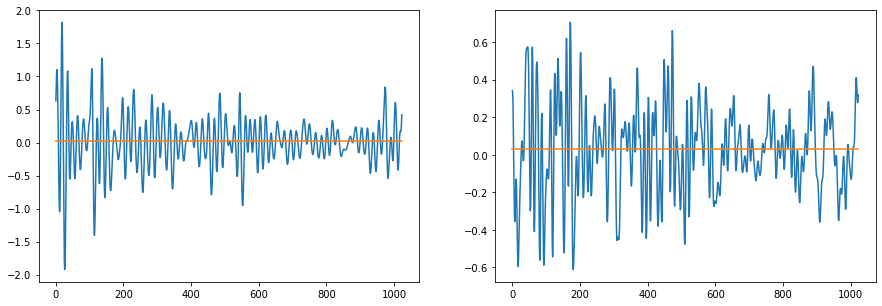

In [14]:
i=8

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(test_set[i,:,0])
plt.plot(Pred_sig[i,:,0])
plt.subplot(1,2,2)
plt.plot(test_set[i,:,1])
plt.plot(Pred_sig[i,:,1])

In [16]:
encoded0 = keras.Model(inputs=model0.input,
                       outputs=model0.get_layer('encoded0').output)

encoded_0 = []
for k in range(test_set.shape[0]//10):
    encoded_0.append(encoded0(test_set[k*10:k*10+10]).numpy())
encoded_0 = np.concatenate(encoded_0,axis = 0)

(-0.015, 0.045)

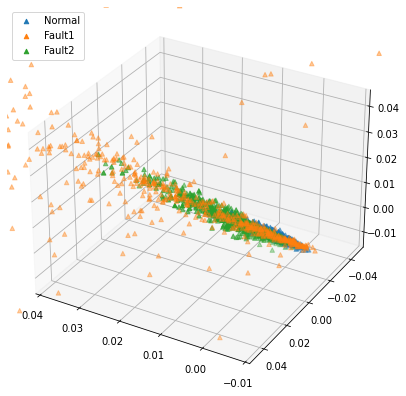

In [15]:
normal_index = test_label[:encoded_0.shape[0]]==0
fault_index1 = test_label[:encoded_0.shape[0]]==1
fault_index2 = test_label[:encoded_0.shape[0]]==2
n_plot = 1000

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    encoded_0[normal_index,0],
    encoded_0[normal_index,1],
    encoded_0[normal_index,2],
    marker='^'
)
ax.scatter(
    encoded_0[0:n_plot][fault_index1[0:n_plot],0],
    encoded_0[0:n_plot][fault_index1[0:n_plot],1],
    encoded_0[0:n_plot][fault_index1[0:n_plot],2],
    marker='^'
)
ax.scatter(
    encoded_0[fault_index2,0][0:],
    encoded_0[fault_index2,1][0:],
    encoded_0[fault_index2,2][0:],
    marker='^'
)

plt.legend(['Normal','Fault1','Fault2'])
ax.azim = 120
ax.elev = 30

ax.set_ylim(-0.05,0.05)
ax.set_xlim(-0.01,0.04)
ax.set_zlim(-0.015,0.045)

In [17]:
def attention_calculate(input_layer,fileter_size,name,method='dense',res=False):
    
    _,layer_len,layer_width = input_layer.shape
    token_time = 10

    token = input_layer[:,0:layer_len-token_time,:]
    for i in range(token_time-1):
        token = layers.Concatenate(axis=-1)([token,input_layer[:,1+i:layer_len-token_time+1+i,:]])
    token = layers.ZeroPadding1D(padding=int(token_time/2))(token)
    
    if method =='dense':
        
        

        attention_k = layers.Dense(fileter_size, activation='relu',name=f'{name}_key1')(token)
        attention_k = layers.Dense(fileter_size*token_time, activation='relu',name=f'{name}_key2')(attention_k)

        attention_q = layers.Dense(fileter_size, activation='relu',name=f'{name}_query1')(token)
        attention_q = layers.Dense(fileter_size*token_time, activation='relu',name=f'{name}_query2')(attention_q)

        attention_v = layers.Dense(fileter_size, activation='relu',name=f'{name}_value1')(token)
        attention_v = layers.Dense(fileter_size,name=f'{name}_value2')(attention_v)
    
    if method == 'convolution':
        if fileter_size// 8 < 2:
            f_s =fileter_size
        else: 
            f_s = fileter_size//8
               
        #f_s =fileter_size
    
        attention_k = layers.Conv1D(filters=f_s,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_key1')(token)
        #attention_k = layers.Conv1D(filters=fileter_size,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_key2')(attention_k)
        attention_k = layers.Conv1D(filters=fileter_size,kernel_size=3,strides=1,padding="same",name=f'{name}_key3')(attention_k)

        attention_q = layers.Conv1D(filters=f_s,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_query1')(token)
        #attention_q = layers.Conv1D(filters=fileter_size,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_query2')(attention_q)
        attention_q = layers.Conv1D(filters=fileter_size,kernel_size=3,strides=1,padding="same",name=f'{name}_query3')(attention_q)

        attention_v = layers.Conv1D(filters=f_s,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_value1')(token)
        #attention_v = layers.Conv1D(filters=fileter_size,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_value2')(attention_v)
        attention_v = layers.Conv1D(filters=fileter_size,kernel_size=3,strides=1,padding="same",name=f'{name}_value3')(attention_v)
    
    attention_v = layers.Permute((2,1))(attention_v)
        
    attention_kq = layers.Dot(axes=2)([attention_q,attention_k])
    
    if res:
        attention_kq = layers.Lambda(lambda x: x)(attention_kq)
    
    #attention_kq = layers.Softmax(axis=1,name=f'{name}_kq')(attention_kq)
    attention_kq =  layers.Activation('relu', name=f'{name}_kq')(attention_kq)
    attention_kq = layers.BatchNormalization(name=f'{name}_normalization')(attention_kq)
 
    attention_score = layers.Dot(axes=2)([attention_kq,attention_v])
    attention_score = layers.Activation('sigmoid', name=f'{name}_score')(attention_score)

    return attention_score,attention_kq

In [18]:
def encoder_block(
    fileter_size,
    fileter_size0,
    kernel_size,
    stride_size,
    input_layer,
    name=None,
    res=False,
    att_method='convolution'
):
    head_num = 3
    attention_score_list = []
    attention_kq_list = []
    
    for i in range(head_num):
        score,kq = attention_calculate(input_layer,fileter_size0,name=f'{name}_attention'+str(i),method=att_method,res=res)
        attention_score_list.append(score)
        attention_kq_list.append(kq)
    if res:
        attention_score = layers.Average()(attention_score_list)
        #attention_score = layers.Lambda(lambda x: 0.5+K.sign(x-K.tile(K.reshape(K.mean(x,axis=1),[-1,1,x.shape[2]]),[1,x.shape[1],1]))/2,name=f'attention_score{name}')(attention_score)
        attention_score = layers.Lambda(lambda x: 1-x,name=f'attention_score{name}')(attention_score)
    else:
        attention_score = layers.Average(name=f'attention_score{name}')(attention_score_list)
        
    attention_kq =  layers.Average(name=f'attention_kq_{name}')(attention_kq_list)
    
    input_att = layers.multiply([attention_score,input_layer])
    output_layer = layers.Conv1D(
        filters=fileter_size,
        kernel_size=kernel_size,
        strides=stride_size,
        padding="same",
        activation="relu",
        name=f'conv_{name}'
    )(input_att)
    #output_layer = tf.keras.layers.MaxPooling1D(
    #    pool_size=2,
    #    strides=2
    #)(output_layer)
    return output_layer,attention_score,attention_kq

In [19]:
def Model_construct(input_sig,cnn_name_list,att_method='convolution'):

    f1,k1,s1 = 32,40,2
    l1 = input_sig0.shape[1]//2
    f2,k2,s2 = 64,20,2
    l2 = l1//2
    f3,k3,s3 = 64,10,2
    l3 = l2//2
    f4,k4,s4 = 32,5,2
    l4 = l3//2
    f5,k5,s5 = 16,3,2
    l5 = l4//2
    if 'res' in cnn_name_list[0]:
        res=True
    else:
        res=False

    f0 = input_sig.shape[2]
    encoded1,attention1,kq1 = encoder_block(f1,f0,k1,s1,input_sig,cnn_name_list[0],res,att_method)
    encoded2,attention2,kq2 = encoder_block(f2,f1,k2,s2,encoded1,cnn_name_list[1],res,att_method)
    encoded3,attention3,kq3 = encoder_block(f3,f2,k3,s3,encoded2,cnn_name_list[2],res,att_method)
    encoded4,attention4,kq4 = encoder_block(f4,f3,k4,s4,encoded3,cnn_name_list[3],res,att_method)
    encoded5,attention5,kq5 = encoder_block(f5,f4,k5,s5,encoded4,cnn_name_list[4],res,att_method)
    encoded5 = layers.Flatten()(encoded5)
    encoded7 = layers.Dense(200,activation="relu",name=cnn_name_list[5])(encoded5)
    encoded8 = layers.Dense(50,activation="relu",name=cnn_name_list[6])(encoded7)
    encoded = layers.Dense(3,name=cnn_name_list[7])(encoded8)
    decoder8 = layers.Dense(50,activation="relu",name=cnn_name_list[8])(encoded)
    decoder7 = layers.Dense(200,activation="relu",name=cnn_name_list[9])(decoder8)
    decoder5 = layers.Dense(l5*f5,activation="relu",name=cnn_name_list[10])(decoder7)
    decoder_5 = layers.Reshape((l5,f5))(decoder5)
    decoder_4 = layers.Conv1DTranspose(filters=f5, kernel_size=k5, strides=2, activation="relu",padding="same",name=cnn_name_list[11])(decoder_5)
    decoder_3 = layers.Conv1DTranspose(filters=f4, kernel_size=k4, strides=2, activation="relu",padding="same",name=cnn_name_list[12])(decoder_4)
    decoder_2 = layers.Conv1DTranspose(filters=f3, kernel_size=k3, strides=2, activation="relu",padding="same",name=cnn_name_list[13])(decoder_3)
    decoder_1 = layers.Conv1DTranspose(filters=f2, kernel_size=k2, strides=2, activation="relu",padding="same",name=cnn_name_list[14])(decoder_2)
    decoded = layers.Conv1DTranspose(filters=f0, kernel_size=k1, strides=2,padding="same",name=cnn_name_list[15])(decoder_1)
    
    attention = [attention1,attention2,attention3,attention4,attention5]
    kq = [kq1,kq2,kq3,kq4,kq5]
    return decoded,attention,kq,encoded

In [20]:
#cnn_name_list = ['block1','block2','block3','block4','encoder_l5','encoder_l6','encoder_l7','encoded',
#                'decoder_l7','decoder_l6','decoder_l5','decoder_l4','decoder_l3','decoder_l2','decoder_l1','decoder_l0']

input_sig = keras.Input(shape=(1024,2),name="input_signal")
decoded,attention,kq,encoded = Model_construct(input_sig,cnn_name_list,'convolution')

attention1,attention2,attention3,attention4,attention5 = attention
kq1,kq2,kq3,kq4,kq5 = kq

model = keras.Model(input_sig, decoded, name="test")

In [21]:
#model.summary()

In [22]:
def set_transfered_model(layer1,layer01):
    model.get_layer(layer1).set_weights(model0.get_layer(layer01).get_weights())
    model.get_layer(layer1).trainable = True
    
for layer_name in cnn_name_list:
    if 'block' in layer_name:
        layer_name = 'conv_'+layer_name
    set_transfered_model(layer_name,layer_name+'0')

In [23]:
eps = 1e-8
reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(input_sig, decoded)))

reg_loss1 =tf.reduce_mean(tf.reduce_sum(K.abs(attention1)))+ tf.reduce_mean(tf.reduce_sum(K.abs(attention2)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention3)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention4)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention5)))
reg_loss2 =tf.reduce_mean(tf.reduce_sum(K.square(attention1)))+ tf.reduce_mean(tf.reduce_sum(K.square(attention2)))+tf.reduce_mean(tf.reduce_sum(K.square(attention3)))+tf.reduce_mean(tf.reduce_sum(K.square(attention4)))+tf.reduce_mean(tf.reduce_sum(K.square(attention5)))
#reg_loss5 =tf.reduce_sum(tf.reduce_sum(K.abs(attention1)))+ tf.reduce_mean(tf.reduce_sum(K.abs(attention2)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention3)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention4)))
reg_loss3 =tf.reduce_mean(tf.reduce_sum(-K.abs(attention1)*K.log(K.abs(attention1+eps))))+ \
tf.reduce_mean(tf.reduce_sum(-K.abs(attention2)*K.log(K.abs(attention2+eps))))+\
tf.reduce_mean(tf.reduce_sum(-K.abs(attention3)*K.log(K.abs(attention3+eps))))+\
tf.reduce_mean(tf.reduce_sum(-K.abs(attention4)*K.log(K.abs(attention4+eps))))+\
tf.reduce_mean(tf.reduce_sum(-K.abs(attention5)*K.log(K.abs(attention5+eps))))

total_loss = reconstruction_loss#+1e-6*reg_loss3#+1e-4*reg_loss1#+1/reg_loss2
model.add_loss(total_loss)

In [24]:
def trans_weight(model1,model):
    for i in model1.layers:
        if i.trainable == True and i.get_weights()!=[]:
            model.get_layer(i.name).set_weights(model1.get_layer(i.name).get_weights())

load_model = 1
if load_model==1:
    model.load_weights('./Models/my_modelv0.h5')
    #model.load_weights('./Models/my_model_tk4.h5')


In [25]:
model.compile(optimizer=keras.optimizers.Adam(),)

model.fit(
    training_set,
    training_set,
    epochs=1,
    batch_size=32
)

# learning rate 1e-3 for 10 epochs as early stop
# learning rate 2e-4 for 30~40 epochs as early stop

In [101]:
#model.save('./Models/my_model_NoSparse.h5')
#model.save('./Models/my_model.h5')

In [26]:
Pred_sig = model.predict(test_set[0:10])

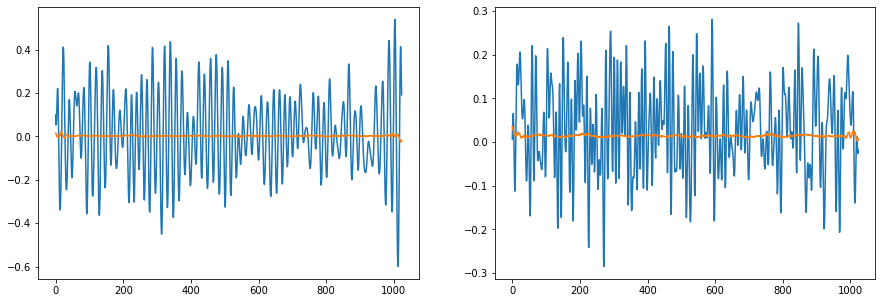

In [27]:
i=7
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(test_set[i,:,0])
plt.plot(Pred_sig[i,:,0])
plt.subplot(1,2,2)
plt.plot(test_set[i,:,1])
plt.plot(Pred_sig[i,:,1])

In [28]:
i=150
head_num = 3

att1_kq = []
for k in range(head_num):
    attention1_kq = keras.Model(inputs=model.input,
                                outputs=model.get_layer('block1_attention'+str(k)+'_kq').output)
    att1_kq.append(attention1_kq(training_set[i:i+1]).numpy()[0])
    
attention1_kq_value = np.mean(att1_kq,axis=0)

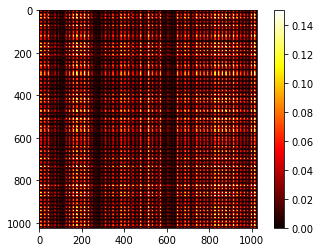

In [29]:
plt.imshow(attention1_kq_value, cmap=plt.cm.hot,vmin=0, vmax=0.15) #,vmin=0, vmax=1
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Channel 1 - attention score')

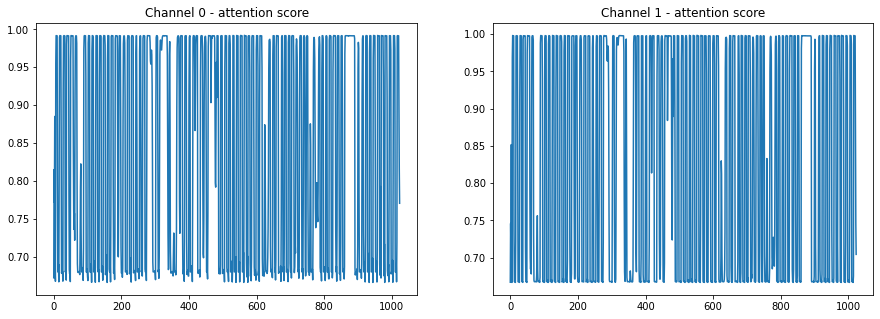

In [30]:
i=7
attention_score_block1 = keras.Model(inputs=model.input,
                                     outputs=model.get_layer('attention_scoreblock1').output)
attention_score1 = attention_score_block1(training_set[i:i+1])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(attention_score1[0,:,0])
plt.title('Channel 0 - attention score')
plt.subplot(1,2,2)
plt.plot(attention_score1[0,:,1])
plt.title('Channel 1 - attention score')

In [32]:
encoded_att = keras.Model(inputs=model.input,
                          outputs=model.get_layer('encoded').output)

encoded_c = []
for k in range(test_set.shape[0]//10):
    encoded_c.append(encoded_att(test_set[k*10:k*10+10]).numpy())
encoded_c = np.concatenate(encoded_c,axis = 0)

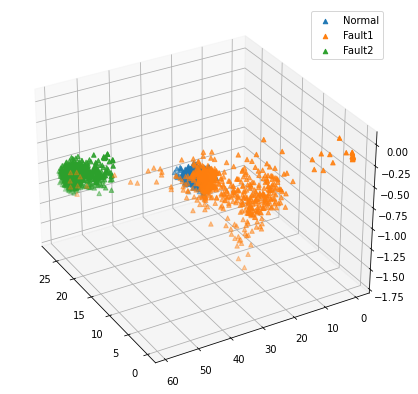

In [36]:
normal_index = test_label[:encoded_c.shape[0]]==0
fault_index1 = test_label[:encoded_c.shape[0]]==1
fault_index2 = test_label[:encoded_c.shape[0]]==2
n_plot = 1000

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    encoded_c[normal_index,0],
    encoded_c[normal_index,1],
    encoded_c[normal_index,2],
    marker='^'
)
ax.scatter(
    encoded_c[0:n_plot][fault_index1[0:n_plot],0],
    encoded_c[0:n_plot][fault_index1[0:n_plot],1],
    encoded_c[0:n_plot][fault_index1[0:n_plot],2],
    marker='^'
)
ax.scatter(
    encoded_c[fault_index2,0][0:],
    encoded_c[fault_index2,1][0:],
    encoded_c[fault_index2,2][0:],
    marker='^'
)
plt.legend(['Normal','Fault1','Fault2'])
ax.azim = 150
ax.elev = 30

##10
#ax.set_ylim(-0.06,0.05)
#ax.set_xlim(-0.04,0.1)
#ax.set_zlim(-0.03,0.07)

##6
#ax.set_ylim(-0.07,-0.01)
#ax.set_xlim(-0.005,0.025)
#ax.set_zlim(-0.015,0.02)

#4
#ax.set_xlim(-0.120,-0.080)
#ax.set_ylim(-0.19,-0.11)
#ax.set_zlim(-0.11,-0.05)

#0
#ax.set_xlim(0.120,0.170)
#ax.set_ylim(-0.07,-0.01)
#ax.set_zlim(0.035,0.065)

#no sparsity
#ax.set_ylim(-0.0386,-0.0374)
#ax.set_xlim(-0.0170,-0.0160)
#ax.set_zlim(-0.0156,-0.01510)
#

In [37]:
cnn_name_list_res = []
for name in cnn_name_list:
    cnn_name_list_res.append(name+"_res")

input_sig_res = keras.Input(shape=(1024,2),name="input_signal_res")
decoded_res,_,_,_ = Model_construct(input_sig_res,cnn_name_list_res)

model_res = keras.Model(input_sig_res,decoded_res, name="test_res")


In [38]:
def set_transfered_model_res1(layer1,layer01):
    model_res.get_layer(layer1).set_weights(model0.get_layer(layer01).get_weights())
    model_res.get_layer(layer1).trainable = False
    
for layer_name in cnn_name_list:
    if 'block' in layer_name:
        layer_name = 'conv_'+layer_name
    set_transfered_model_res1(layer_name+'_res',layer_name+'0')

In [39]:
def set_transfered_model_res2(layer1_res,layer1):
    model_res.get_layer(layer1_res).set_weights(model.get_layer(layer1).get_weights())
    model_res.get_layer(layer1_res).trainable = True


att_method = "convolution"
if att_method=="dense":
    attention_name_list = ['_key1','_key2','_query1','_query2','_value1','_value2']
elif att_method=="convolution":
    #attention_name_list = ['_key1','_key2','_key3','_query1','_query2','_query3','_value1','_value2','_value3']
    attention_name_list = ['_key1','_key3','_query1','_query3','_value1','_value3']
    
transfer_list_res=[]
head_num = 3

for layer_name in cnn_name_list:
    if 'block' in layer_name:
        for k in range(head_num):
            set_transfered_model_res2(layer_name+'_res_attention'+str(k)+'_normalization',
                                      layer_name+'_attention'+str(k)+'_normalization')
            for attention_layer_name in attention_name_list:
                set_transfered_model_res2(layer_name+'_res_attention'+str(k)+attention_layer_name,
                                          layer_name+'_attention'+str(k)+attention_layer_name)

In [40]:
Pred_sig = model_res.predict(test_set[0:20])

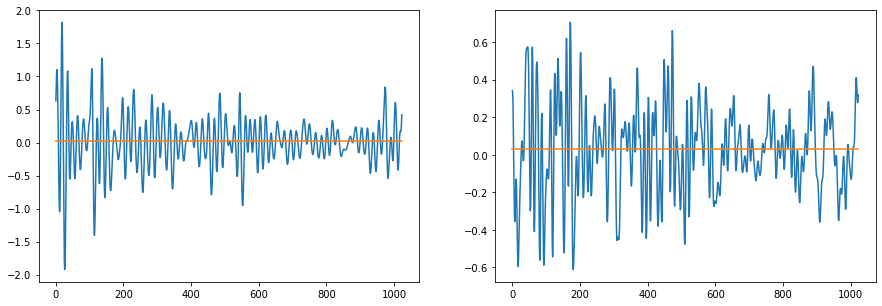

In [41]:
i=8
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(test_set[i,:,0])
plt.plot(Pred_sig[i,:,0])
plt.subplot(1,2,2)
plt.plot(test_set[i,:,1])
plt.plot(Pred_sig[i,:,1])

Text(0.5, 1.0, 'Channel 1 - attention score')

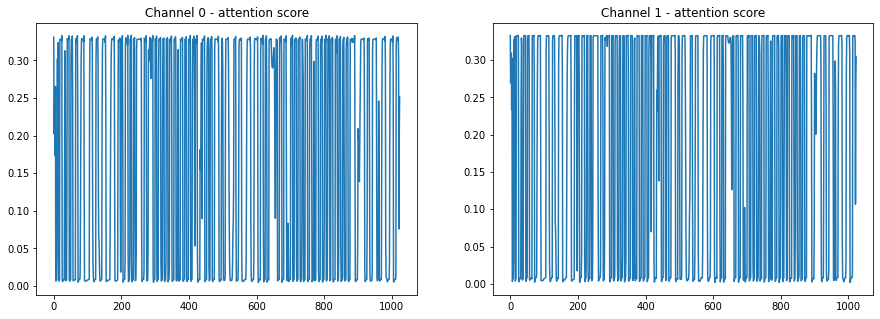

In [42]:
i=15
attention_score_block1_res = keras.Model(inputs=model_res.input,
                                         outputs=model_res.get_layer('attention_scoreblock1_res').output)
attention_score1_res = attention_score_block1_res(training_set[i:i+1])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(attention_score1_res[0,:,0])
plt.title('Channel 0 - attention score')
plt.subplot(1,2,2)
plt.plot(attention_score1_res[0,:,1])
plt.title('Channel 1 - attention score')

# Res

In [ ]:
encoded_att_res = keras.Model(inputs=model_res.input,
                              outputs=model_res.get_layer('encoded_res').output)

encoded_attres = []
for k in range(test_set.shape[0]//10):
    encoded_attres.append(encoded_att_res(test_set[k*10:k*10+10]).numpy())
encoded_attres = np.concatenate(encoded_attres,axis = 0)

In [ ]:
normal_index = test_label[:encoded_attres.shape[0]]==0
fault_index1 = test_label[:encoded_attres.shape[0]]==1
fault_index2 = test_label[:encoded_attres.shape[0]]==2
n_plot = 0

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    encoded_attres[normal_index,0],
    encoded_attres[normal_index,1],
    encoded_attres[normal_index,2],
    marker='^'
)
ax.scatter(
    encoded_attres[0:n_plot][fault_index1[0:n_plot],0],
    encoded_attres[0:n_plot][fault_index1[0:n_plot],1],
    encoded_attres[0:n_plot][fault_index1[0:n_plot],2],
    marker='^'
)
ax.scatter(
    encoded_attres[fault_index2,0][0:],
    encoded_attres[fault_index2,1][0:],
    encoded_attres[fault_index2,2][0:],
    marker='^'
)
plt.legend(['Normal','Fault1','Fault2'])
ax.azim = 60
ax.elev = 30

#x.set_ylim(-0.0404639,-0.0404633)
#x.set_xlim(-0.0155742,-0.0155738)
#x.set_zlim(-0.0152635,-0.0152632)

# Classification

In [28]:
encoded_att_pcp = keras.Model(inputs=model.input,
                              outputs=model.get_layer('encoded').output)

#latent_pcp = []
latent_pcp0 = []
for k in range(Dataset.shape[0]//10):
    latent_pcp0.append(encoded_att_pcp(Dataset[k*10:k*10+10]).numpy())
latent_pcp0 = np.concatenate(latent_pcp0,axis = 0)

In [29]:
latents = latent_pcp0
n__=latents.shape[0]
label_ = label[:n__]

shuffle_id = np.random.permutation(np.arange(n__))
latents = latents[shuffle_id]
label_ = label_[shuffle_id]

# KDE

In [89]:
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [99]:
### TEST ###

acc = 0
recall1 = 0
recall2 = 0

n_train = int(n__*0.50)

normal_index = label_==0
anomaly1_index = label_==1
anomaly2_index = label_==2

bd = 1e-5
kde_3d_normal = KernelDensity(bandwidth=bd, kernel='gaussian', algorithm='ball_tree')
kde_3d_normal.fit(latents[:n_train][normal_index[:n_train],:])
kde_3d_anomaly1 = KernelDensity(bandwidth=bd, kernel='gaussian', algorithm='ball_tree')
kde_3d_anomaly1.fit(latents[:n_train][anomaly1_index[:n_train],:])
kde_3d_anomaly2 = KernelDensity(bandwidth=1*bd, kernel='gaussian', algorithm='ball_tree')
kde_3d_anomaly2.fit(latents[:n_train][anomaly2_index[:n_train],:])


positive_score = kde_3d_normal.score_samples(latents[n_train:])
negative1_score = kde_3d_anomaly1.score_samples(latents[n_train:])
negative2_score = kde_3d_anomaly2.score_samples(latents[n_train:])

score_ = np.concatenate([positive_score.reshape(-1,1),
                         negative1_score.reshape(-1,1),
                         negative2_score.reshape(-1,1)],
                       axis = 1)
prediction = np.argmax(score_, axis=1)

for i in range(len(prediction)):
    if prediction[i]==label_[n_train+i]:
        acc += 1
        if label_[n_train+i]==1:
            recall1+=1
        elif label_[n_train+i]==2:
            recall2+=1
            
acc = acc/len(score_)
recall1 = recall1/len(label_[n_train:][label_[n_train:]==1])
recall2 = recall2/len(label_[n_train:][label_[n_train:]==2])

print('Accuracy:',acc)
print('Recall1:',recall1)
print('Recall2:',recall2)
print('AvgRecall:',(recall1+recall2)/2)


Accuracy: 0.8671140939597315
Recall1: 0.8730874536962474
Recall2: 0.9656061908856406
AvgRecall: 0.919346822290944


In [54]:
##Experiment##

#number = [30, 49, 81, 163, 491, 819, 1639, 3278, 8195, 11473,14751]
number = [n_train]
#Accu = []
#Recal = []
Accu_bb = []
Recal_bb = []
for n_train in number:
    acc = 0
    recall1 = 0
    recall2 = 0
    for i in range(5):
        shuffle_id = np.random.permutation(np.arange(n__))
        latents = latents[shuffle_id]
        label_ = label_[shuffle_id]
        #n_train = int(n__*0.7)
        #print(n_train)
        normal_index = label_==0
        anomaly1_index = label_==1
        anomaly2_index = label_==2

        bd = 5e-5
        kde_3d_normal = KernelDensity(bandwidth=bd, kernel='gaussian', algorithm='ball_tree')
        kde_3d_normal.fit(latents[:n_train][normal_index[:n_train],:])
        kde_3d_anomaly1 = KernelDensity(bandwidth=bd, kernel='gaussian', algorithm='ball_tree')
        kde_3d_anomaly1.fit(latents[:n_train][anomaly1_index[:n_train],:])
        kde_3d_anomaly2 = KernelDensity(bandwidth=bd*1, kernel='gaussian', algorithm='ball_tree')
        kde_3d_anomaly2.fit(latents[:n_train][anomaly2_index[:n_train],:])


        positive_score = kde_3d_normal.score_samples(latents[n_train:])
        negative1_score = kde_3d_anomaly1.score_samples(latents[n_train:])
        negative2_score = kde_3d_anomaly2.score_samples(latents[n_train:])

        score_ = np.concatenate([positive_score.reshape(-1,1),
                                 negative1_score.reshape(-1,1),
                                 negative2_score.reshape(-1,1)],
                               axis = 1)
        prediction = np.argmax(score_, axis=1)

        for i in range(len(prediction)):
            if prediction[i]==label_[n_train+i]:
                acc += 1
                if label_[n_train+i]==1:
                    recall1+=1
                elif label_[n_train+i]==2:
                    recall2+=1
    acc = acc/len(score_)/5
    recall1 = recall1/5/len(label_[n_train:][label_[n_train:]==1])
    recall2 = recall2/5/len(label_[n_train:][label_[n_train:]==2])

    Accu_bb.append(acc)
    Recal_bb.append((recall1+recall2)/2)


KeyboardInterrupt: 

In [ ]:
print('Accuracy:',Accu_bb)
print('AvgRecall:',Recal_bb)

NameError: name 'Accu' is not defined

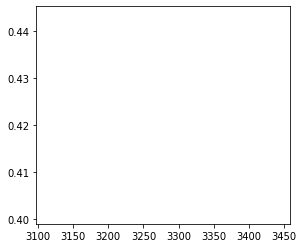

In [94]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(number,Accu_bb,label='Backbone')
plt.plot(number,Accu,label='Proposed')
#plt.title('Accuracy')
plt.legend(['Backbone','Proposed'])
plt.semilogx()
plt.ylim(0.4,1)
plt.grid()
plt.xlabel('label number')
plt.ylabel('accuracy')

plt.subplot(1,2,2)
plt.plot(number,Recal_bb,label='Backbone')
plt.plot(number,Recal,label='Proposed')
#plt.title('Recall')
plt.legend(['Backbone','Proposed'])
plt.semilogx()
plt.ylim(0.4,1)
plt.grid()
plt.xlabel('label number')
plt.ylabel('recall')

# KDE_Anomaly

In [30]:
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [176]:
acc_=[]
recall1_=[]
recall2_=[]
n_train_=[]
for i in range(1,9):
    _acc_ = 0
    _recall1_ = 0
    _recall2_ = 0
    
    for j in range(5):
        shuffle_id = np.random.permutation(np.arange(n__))
        latents = latents[shuffle_id]
        label_ = label_[shuffle_id]

        normal_index = label_==0
        anomaly1_index = label_==1
        anomaly2_index = label_==2
        
        n_train = int(n__*i/10)
        acc = 0
        recall1 = 0
        recall2 = 0
        
        normal_index = label_==0
        anomaly1_index = label_==1
        anomaly2_index = label_==2
        
        bd = 2e-5
        kde_3d_normal = KernelDensity(bandwidth=bd, kernel='gaussian', algorithm='ball_tree')
        kde_3d_normal.fit(latents[:n_train][normal_index[:n_train],:])
        kde_3d_anomaly1 = KernelDensity(bandwidth=bd, kernel='gaussian', algorithm='ball_tree')
        kde_3d_anomaly1.fit(latents[:n_train][anomaly1_index[:n_train],:])
        
        
        positive_score = kde_3d_normal.score_samples(latents[n_train:])
        negative1_score = kde_3d_anomaly1.score_samples(latents[n_train:])
        negative2_score = -1.3e7*np.ones(len(negative1_score))
        
        score_ = np.concatenate([positive_score.reshape(-1,1),
                                 negative1_score.reshape(-1,1),
                                 negative2_score.reshape(-1,1)],
                                axis = 1)
        prediction = np.argmax(score_, axis=1)
        
        for k in range(len(prediction)):
            if prediction[k]==label_[n_train+k]:
                acc += 1
                if label_[n_train+k]==1:
                    recall1+=1
                elif label_[n_train+k]==2:
                    recall2+=1
                    
        acc = acc/len(score_)
        recall1 = recall1/len(label_[n_train:][label_[n_train:]==1])
        recall2 = recall2/len(label_[n_train:][label_[n_train:]==2])
        
        _acc_+=acc
        _recall1_ += recall1
        _recall2_ += recall2
    
    acc_.append(_acc_/5)
    recall1_.append(_recall1_/5)
    recall2_.append(_recall2_/5)
    n_train_.append(n_train)
        

#print('Accuracy:',acc)
#print('Recall1:',recall1)
#print('Recall2:',recall2)
#print('AvgRecall:',(recall1+recall2)/2)


#score_ = np.concatenate([positive_score.reshape(-1,1),
#                         negative1_score.reshape(-1,1)]
#                        axis = 1)
#plt.plot(np.sort(np.max(score_, axis=1))[1000:])

Text(0.5, 0, 'label number')

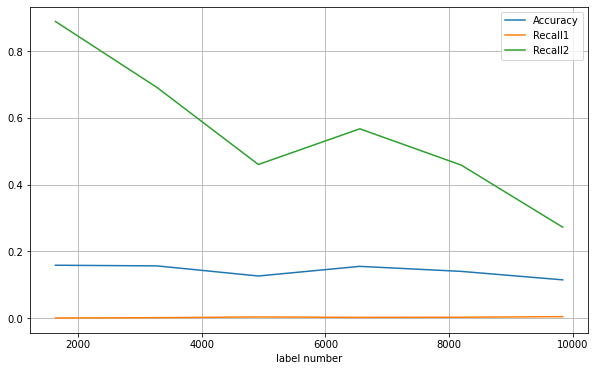

In [177]:
plt.figure(figsize=(10,6))
plt.plot(n_train_[:6],acc_[:6],label='Accuracy')
plt.plot(n_train_[:6],recall1_[:6],label='Recall1')
plt.plot(n_train_[:6],recall2_[:6],label='Recall2')
plt.legend(['Accuracy','Recall1','Recall2'])
#plt.ylim(0.4,1)
plt.grid()
plt.xlabel('label number')

In [201]:
acc_=[]
recall1_=[]
recall2_=[]
n_train_=[]
for i in range(1,9):
    _acc_ = 0
    _recall1_ = 0
    _recall2_ = 0
    
    for j in range(5):
        shuffle_id = np.random.permutation(np.arange(n__))
        latents = latents[shuffle_id]
        label_ = label_[shuffle_id]

        normal_index = label_==0
        anomaly1_index = label_==1
        anomaly2_index = label_==2
        
        n_train = int(n__*i/10)
        acc = 0
        recall1 = 0
        recall2 = 0
        
        normal_index = label_==0
        anomaly1_index = label_==1
        anomaly2_index = label_==2
        
        bd = 2e-5
        kde_3d_normal = KernelDensity(bandwidth=bd, kernel='gaussian', algorithm='ball_tree')
        kde_3d_normal.fit(latents[:n_train][normal_index[:n_train],:])
        kde_3d_anomaly1 = KernelDensity(bandwidth=bd, kernel='gaussian', algorithm='ball_tree')
        kde_3d_anomaly1.fit(latents[:n_train][anomaly2_index[:n_train],:])
        
        
        positive_score = kde_3d_normal.score_samples(latents[n_train:])
        negative1_score = kde_3d_anomaly1.score_samples(latents[n_train:])
        negative2_score = -4e6*np.ones(len(negative1_score))
        
        score_ = np.concatenate([positive_score.reshape(-1,1),
                                 negative2_score.reshape(-1,1),
                                 negative1_score.reshape(-1,1)],
                                axis = 1)
        prediction = np.argmax(score_, axis=1)
        
        for k in range(len(prediction)):
            if prediction[k]==label_[n_train+k]:
                acc += 1
                if label_[n_train+k]==1:
                    recall1+=1
                elif label_[n_train+k]==2:
                    recall2+=1
                    
        acc = acc/len(score_)
        recall1 = recall1/len(label_[n_train:][label_[n_train:]==1])
        recall2 = recall2/len(label_[n_train:][label_[n_train:]==2])
        
        _acc_+=acc
        _recall1_ += recall1
        _recall2_ += recall2
    
    acc_.append(_acc_/5)
    recall1_.append(_recall1_/5)
    recall2_.append(_recall2_/5)
    n_train_.append(n_train)
        

#print('Accuracy:',acc)
#print('Recall1:',recall1)
#print('Recall2:',recall2)
#print('AvgRecall:',(recall1+recall2)/2)


#score_ = np.concatenate([positive_score.reshape(-1,1),
#                         negative1_score.reshape(-1,1)]
#                        axis = 1)
#plt.plot(np.sort(np.max(score_, axis=1))[1000:])

Text(0.5, 0, 'label number')

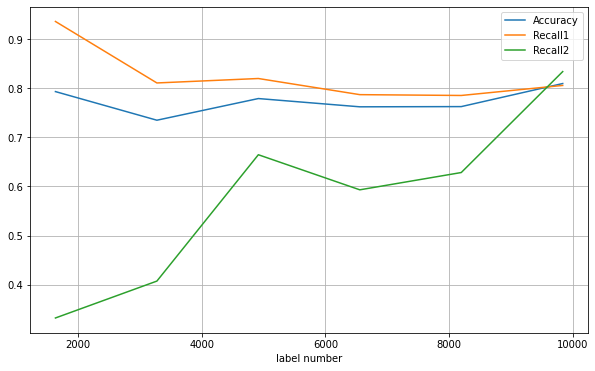

In [202]:
plt.figure(figsize=(10,6))
plt.plot(n_train_[:6],acc_[:6],label='Accuracy')
plt.plot(n_train_[:6],recall1_[:6],label='Recall1')
plt.plot(n_train_[:6],recall2_[:6],label='Recall2')
plt.legend(['Accuracy','Recall1','Recall2'])
#plt.ylim(0.4,1)
plt.grid()
plt.xlabel('label number')